In [354]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, ElasticNet, RidgeCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.ensemble import RandomForestRegressor
import re
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


In [18]:
# Import the data

demographics = pd.read_csv('new_Data/demographics_4_Guilia.csv')

ROIs = pd.read_csv("new_Data/dka_HCP_test.csv")
ROIs = ROIs["name"]
columns = [ROI + "_" + str(j/2) for ROI in ROIs for j in range(0, 300)]

psds = pd.read_csv('new_Data/PSD_Rest.csv', header=None)
psds.columns = columns

In [19]:
psds.head()

,bankssts L_0.0,bankssts L_0.5,bankssts L_1.0,bankssts L_1.5,bankssts L_2.0,bankssts L_2.5,bankssts L_3.0,bankssts L_3.5,bankssts L_4.0,bankssts L_4.5,...,transversetemporal R_145.0,transversetemporal R_145.5,transversetemporal R_146.0,transversetemporal R_146.5,transversetemporal R_147.0,transversetemporal R_147.5,transversetemporal R_148.0,transversetemporal R_148.5,transversetemporal R_149.0,transversetemporal R_149.5
0,1.166112,7.310916,5.172159,2.908277,1.780837,1.194868,1.090405,1.041240,0.966275,0.866052,...,0.013225,0.014056,0.012924,0.011307,0.011478,0.011786,0.010631,0.009448,0.006987,0.003150
1,1.726824,11.262225,8.457395,5.106392,3.424434,2.753602,2.462952,2.272813,2.133286,1.975146,...,0.019069,0.017784,0.018208,0.019443,0.018315,0.017127,0.016271,0.015401,0.010584,0.007986
2,1.283245,8.512901,5.622469,3.662541,2.693076,2.195658,1.881473,1.665905,1.550854,1.544194,...,0.011910,0.012364,0.012478,0.012050,0.011816,0.012486,0.011117,0.009719,0.007808,0.003464
3,0.779096,5.631812,4.190357,2.781331,2.186175,2.060094,1.706472,1.454541,1.415902,1.377155,...,0.007378,0.007126,0.007329,0.007236,0.006535,0.006806,0.006740,0.006133,0.004261,0.002017
4,0.843786,5.370334,4.005501,2.143103,1.772349,1.449305,1.291349,1.441181,1.354650,1.279961,...,0.005973,0.006015,0.006312,0.005653,0.005771,0.005979,0.005880,0.005315,0.003970,0.001791


In [20]:
demographics.head()

,Unnamed: 0,CCID,homeint_sex,homeint_duration,homeint_mmse_i,homeint_handedness,homeint_quitquestion,homeint_v1,homeint_v19,homeint_v20,...,additional_attention_orientation,additional_memory,additional_fluencies,additional_language,additional_visuospatial,additional_acer,Catell_score,age,Group,Sex
0,2,sub_CC110033,M,63.0,30.0,90.0,NaN,1.0,1.0,NaN,...,18.0,24.0,13.0,26.0,16.0,97.0,NaN,24.17,young adult,MALE
1,3,sub_CC110037,M,559.0,30.0,89.0,NaN,1.0,1.0,NaN,...,18.0,26.0,14.0,26.0,16.0,100.0,30.0,18.75,young adult,MALE
2,5,sub_CC110045,F,132.0,30.0,100.0,NaN,2.0,1.0,NaN,...,18.0,26.0,14.0,26.0,16.0,100.0,41.0,24.50,young adult,FEMALE
3,6,sub_CC110056,F,80.0,29.0,100.0,NaN,2.0,1.0,NaN,...,17.0,26.0,12.0,26.0,14.0,95.0,24.0,22.67,young adult,FEMALE
4,10,sub_CC110069,F,-184.0,28.0,-58.0,NaN,2.0,1.0,NaN,...,16.0,26.0,14.0,23.0,15.0,94.0,41.0,28.67,young adult,FEMALE


In [21]:
# Apply log to the PSDs

psds = np.log(psds)

In [22]:
df = demographics[["Catell_score", "age"]]
df.dropna(axis = 0, inplace=True)
pearsonr(df["age"], df["Catell_score"])

/var/folders/bx/pchp8hxx2k9gdgpwhgy8fpvc0000gn/T/ipykernel_40086/2729761496.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(axis = 0, inplace=True)


PearsonRResult(statistic=-0.6698398342941214, pvalue=9.462756898167437e-80)

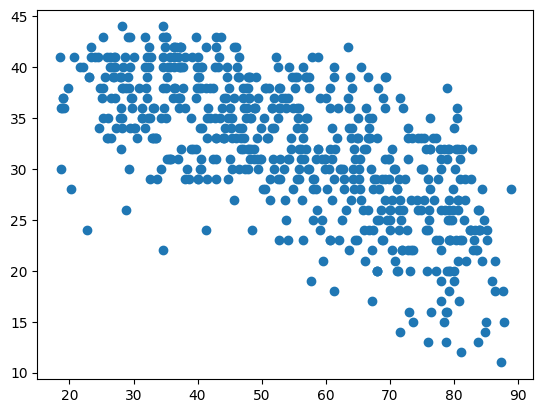

In [23]:
plt.scatter(df["age"], df["Catell_score"])

# 1. Predict global scores from every feature

In [889]:
# Remove old people (ie age > 45)

# mask = demographics["Group"] == "young adult"
# demographics = demographics[mask]
# psds = psds[mask]

In [932]:
# To predict
col_to_predict = "Catell_score"
y = demographics[col_to_predict]
y = y.to_numpy()

# Features
X = psds.to_numpy()

# Remove Nan Values
index = np.where(np.isnan(y) == True)[0]
X = np.delete(X, index, axis=0)
y = np.delete(y, index, axis=0)

# Remove the outliers, ex here one with a score of 0
index = np.where(y == 0)[0]
X = np.delete(X, index, axis=0)
y = np.delete(y, index, axis=0)

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [933]:
# Standardization of the input
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [915]:
# # Standardization of the output

# scaler_output = StandardScaler()

# y_train = scaler_output.fit_transform(y_train.reshape(-1, 1))
# y_test = scaler_output.transform(y_test.reshape(-1, 1))

In [916]:
# PCA
pca = PCA(n_components=68)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [917]:
np.sum(pca.explained_variance_ratio_)

0.9134282261926239

In [934]:
# Linear Rigde Regression
lr = Lasso(alpha=0.5)
lr.fit(X_train, y_train)

lr.score(X_train, y_train), lr.score(X_test, y_test)

(0.44978077060196764, 0.3300053814762065)

MSE training :  24.883652599847238
MSE test :  31.058088195334218
Correlation test :  PearsonRResult(statistic=0.5841924835211214, pvalue=5.991164715713126e-18)


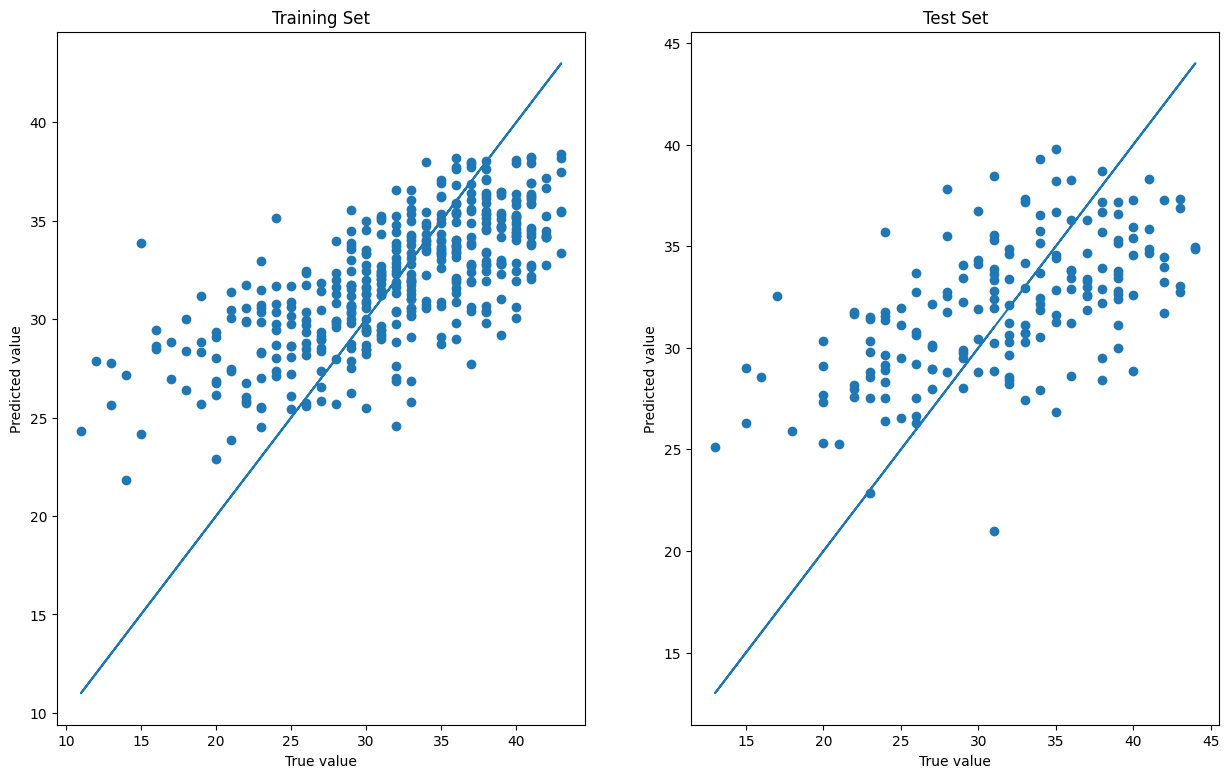

In [935]:
_, (ax0, ax1) = plt.subplots(figsize = (15, 9), ncols=2)

y_train_pred = lr.predict(X_train)
# y_train, y_train_pred = scaler_output.inverse_transform(y_train), scaler_output.inverse_transform(y_train_pred)
print("MSE training : ", mean_squared_error(y_train, y_train_pred))

ax0.scatter(x=y_train, y=y_train_pred)
ax0.plot(y_train, y_train)
ax0.set_title("Training Set")
ax0.set_xlabel("True value")
ax0.set_ylabel("Predicted value")

y_test_pred = lr.predict(X_test)
# y_test, y_test_pred = scaler_output.inverse_transform(y_test), scaler_output.inverse_transform(y_test_pred)
print("MSE test : ", mean_squared_error(y_test, y_test_pred))

ax1.scatter(x=y_test, y=y_test_pred)
ax1.plot(y_test, y_test)
ax1.set_title("Test Set")
ax1.set_xlabel("True value")
ax1.set_ylabel("Predicted value")

print("Correlation test : ", pearsonr(y_test, y_test_pred))


In [828]:
def train_and_predict(X, y, test_split = 0.2, nb_components_pca = 10, standard_input = True, standard_output = False, model = Ridge(), plot = True) :

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_split)

    if standard_input :
        # Standardization of the input
        scaler = StandardScaler()

        X_train = scaler.fit_transform(X_train)
        X_test = scaler.fit_transform(X_test)

    if standard_output :
        # Standardization of the output

        scaler_output = StandardScaler()

        y_train = scaler_output.fit_transform(y_train.reshape(-1, 1))
        y_test = scaler_output.transform(y_test.reshape(-1, 1))

        y_train = y_train.reshape(-1,)
        y_test = y_test.reshape(-1,)

    if nb_components_pca :
        # PCA
        pca = PCA(n_components=50)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)

    # Linear Rigde Regression
    lr = model
    lr.fit(X_train, y_train)

    y_train_pred = lr.predict(X_train)
    y_test_pred = lr.predict(X_test)

    # Plot results
    if plot :
        _, (ax0, ax1) = plt.subplots(figsize = (15, 9), ncols=2)

        print("MSE training : ", mean_squared_error(y_train, y_train_pred))

        ax0.scatter(x=y_train, y=y_train_pred)
        ax0.plot(y_train, y_train)
        ax0.set_title("Training Set")
        ax0.set_xlabel("True value")
        ax0.set_ylabel("Predicted value")

        y_test_pred = lr.predict(X_test)
        print("MSE test : ", mean_squared_error(y_test, y_test_pred))

        ax1.scatter(x=y_test, y=y_test_pred)
        ax1.plot(y_test, y_test)
        ax1.set_title("Test Set")
        ax1.set_xlabel("True value")
        ax1.set_ylabel("Predicted value")

        plt.show()
    
    return pearsonr(y_test, y_test_pred)[0]

In [936]:
# Good result for now on:

test_split = 0.2
nb_components_pca = None
standard_input = True
standard_output = False
model = Lasso(alpha=0.5)
plot = False

corr = []

for _ in tqdm(range(100), total = 100):
    correlation = train_and_predict(X, y, test_split, nb_components_pca, standard_input, standard_output, model, plot)
    corr.append(correlation)

100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


In [937]:
np.mean(corr), np.std(corr)

(0.5575322255310067, 0.04912086607473273)

0.5575322255310067 0.04912086607473273


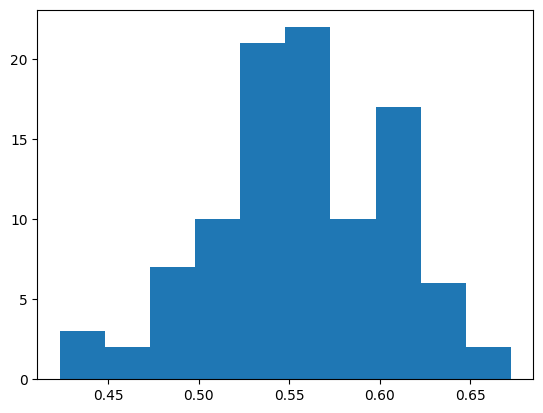

In [938]:
print(np.mean(corr), np.std(corr))
plt.hist(corr, bins = 10)
plt.show()

# Try to keep only some frequencies

In [910]:
cols_to_keep = [c for c in psds.columns if  float(re.search("[0-9]+\.[0-9]*", c).group(0)) >= 1.0 and float(re.search("[0-9]+\.[0-9]*", c).group(0)) < 50.0]

In [911]:
# To predict
col_to_predict = "Catell_score"
y = demographics[col_to_predict]
y = y.to_numpy()

# Features
X = psds[cols_to_keep]
X = X.to_numpy()

# Remove Nan Values
index = np.where(np.isnan(y) == True)[0]
X = np.delete(X, index, axis=0)
y = np.delete(y, index, axis=0)

# Remove the outliers, ex here one with a score of 0
index = np.where(y == 0)[0]
X = np.delete(X, index, axis=0)
y = np.delete(y, index, axis=0)


test_split = 0.2
nb_components_pca = 68
standard_input = True
standard_output = False
model = Ridge(alpha=10.0)
plot = False
corr = []

for _ in tqdm(range(10), total=10):
    correlation = train_and_predict(X, y, test_split, nb_components_pca, standard_input, standard_output, model, plot)
    corr.append(correlation)


100%|██████████| 10/10 [00:47<00:00,  4.73s/it]


0.5421190464870508 0.04462600901155257


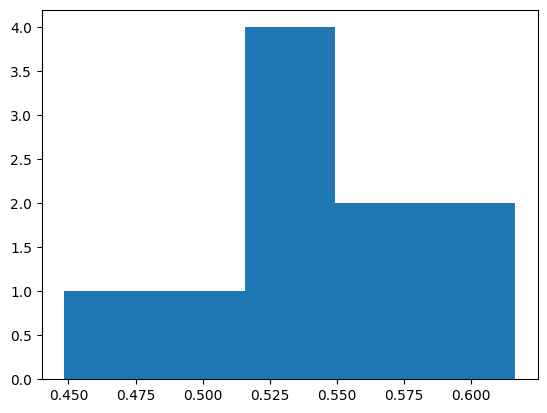

In [912]:
print(np.mean(corr), np.std(corr))
plt.hist(corr, bins = 5)
plt.show()

# With DL

In [411]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, Input, Dropout
from tensorflow.keras import Model

Epoch 1/20
8/8 [==============================] - 1s 104ms/step - loss: 2.1168 - mae: 2.1168 - val_loss: 0.8172 - val_mae: 0.8172
Epoch 2/20
8/8 [==============================] - 0s 36ms/step - loss: 1.2351 - mae: 1.2351 - val_loss: 0.7511 - val_mae: 0.7511
Epoch 3/20
8/8 [==============================] - 0s 36ms/step - loss: 0.8922 - mae: 0.8922 - val_loss: 0.5598 - val_mae: 0.5598
Epoch 4/20
8/8 [==============================] - 0s 31ms/step - loss: 0.7315 - mae: 0.7315 - val_loss: 0.4608 - val_mae: 0.4608
Epoch 5/20
8/8 [==============================] - 0s 26ms/step - loss: 0.5316 - mae: 0.5316 - val_loss: 0.3151 - val_mae: 0.3151
Epoch 6/20
8/8 [==============================] - 0s 34ms/step - loss: 0.4882 - mae: 0.4882 - val_loss: 0.2781 - val_mae: 0.2781
Epoch 7/20
8/8 [==============================] - 0s 39ms/step - loss: 0.4568 - mae: 0.4568 - val_loss: 0.3280 - val_mae: 0.3280
Epoch 8/20
8/8 [==============================] - 0s 27ms/step - loss: 0.4349 - mae: 0.4349 - va

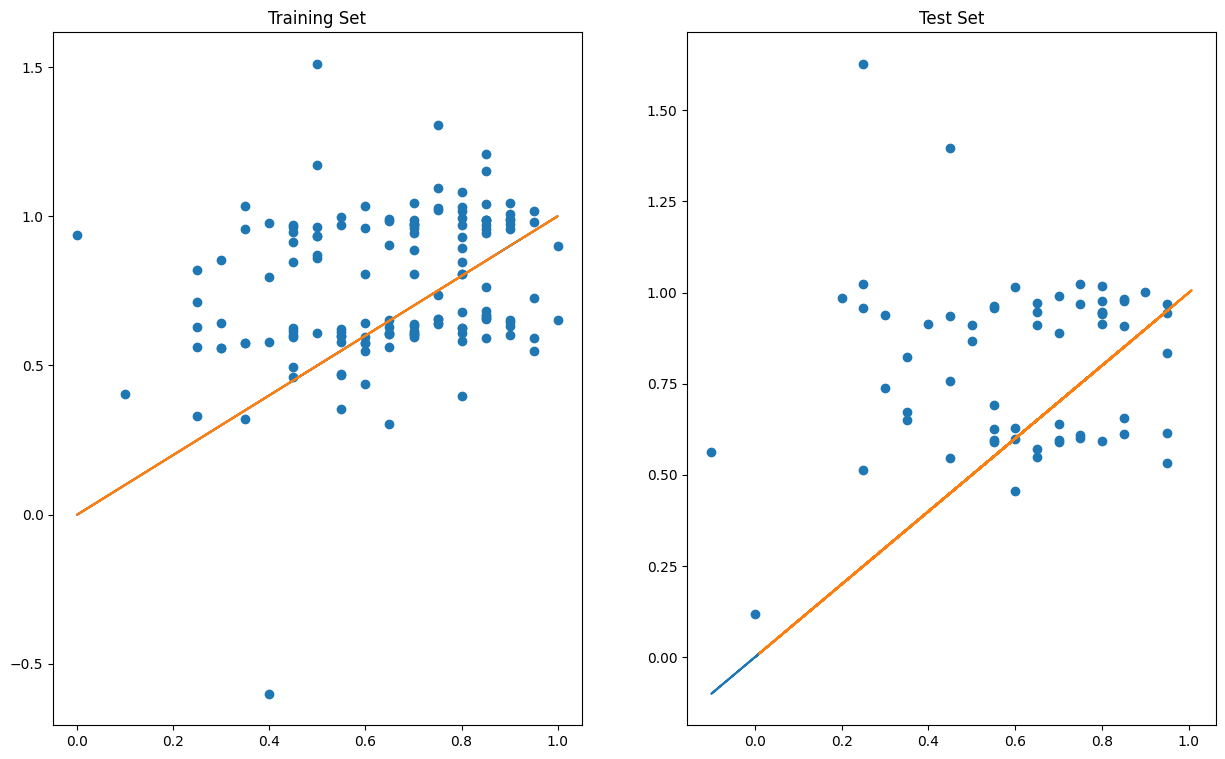

In [539]:
# To predict
col_to_predict = ["Catell_score", "age"]
y = demographics[col_to_predict]
y = y.to_numpy()

# Features
X = psds.copy()
X = X.to_numpy()

# Remove Nan Values
index = np.where(np.isnan(y) == True)[0]
X = np.delete(X, index, axis=0)
y = np.delete(y, index, axis=0)

# Remove the outliers, ex here one with a score of 0
index = np.where(y == 0)[0]
X = np.delete(X, index, axis=0)
y = np.delete(y, index, axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Standardization of the input
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


scaler_output = MinMaxScaler()

y_train = scaler_output.fit_transform(y_train)
y_test = scaler_output.transform(y_test)

# Create model
input = Input(shape=(X.shape[1]))
hidden = Dense(1024, activation = "sigmoid")(input)
hidden = Dropout(0.2)(hidden)
hidden = BatchNormalization()(hidden)
hidden = Dense(512, activation = "sigmoid")(hidden)
hidden = Dropout(0.2)(hidden)
hidden = BatchNormalization()(hidden)
output = Dense(2)(hidden)

model = Model(inputs = input, outputs = output)

model.compile(loss = "mae", optimizer="adam", metrics=["mae"])

#Fit model
model.fit(X_train, y_train, epochs = 20, validation_split = 0.2, batch_size=16)

# Plot results
_, (ax0, ax1) = plt.subplots(figsize = (15, 9), ncols=2)

y_train_pred = model.predict(X_train)
print("MSE training : ", mean_squared_error(y_train, y_train_pred))

ax0.scatter(x=y_train[:,0], y=y_train_pred[:,0])
ax0.plot(y_train, y_train)
ax0.set_title("Training Set")

y_test_pred = model.predict(X_test)
print("MSE test : ", mean_squared_error(y_test, y_test_pred))

ax1.scatter(x=y_test[:,0], y=y_test_pred[:,0])
ax1.plot(y_test, y_test)
ax1.set_title("Test Set")

plt.show()

# New features processing

## Average per band

In [837]:
BROADBAND = (0.0, 150.0)
DELTA = (0.0, 4.0)
THETA = (4.0, 8.0)
ALPHA = (8.0, 13.0)
BETA = (13.0, 30.0)
GAMMA = (30.0, 50.0)
HIGH_GAMMA = (50.0, 150.0)

bands = [DELTA, THETA, ALPHA, BETA, GAMMA, HIGH_GAMMA]

In [838]:
avg_psds = np.zeros((psds.shape[0],6))

for k, band in enumerate(bands):
    columns_band_freq = [c for c in psds.columns if float(re.search("[0-9]+\.[0-9]*", c).group(0)) >= band[0] and float(re.search("[0-9]+\.[0-9]*", c).group(0)) < band[1]]
    psds_band = psds[columns_band_freq]
    avg_psds[:, k] = np.mean(psds_band, axis=1)

In [839]:
avg_psds = pd.DataFrame(avg_psds, columns = ["Delta", "Theta", "Alpha", "Beta", "Gamma", "High Gamma"]) 
avg_psds.head()

,Delta,Theta,Alpha,Beta,Gamma,High Gamma
0,1.273034,0.128179,0.178182,-0.498392,-2.028279,-2.708362
1,1.237832,0.319975,0.002091,-0.996203,-2.101035,-2.820252
2,1.278823,0.538073,0.230532,-0.872427,-2.056754,-2.827937
3,1.227882,0.543446,-0.005334,-0.697368,-2.467764,-3.429071
4,0.979032,0.532299,0.716635,-0.373444,-2.125706,-3.133347


In [841]:
# To predict
col_to_predict = "age"
y = demographics[col_to_predict]
y = y.to_numpy()

# Features
X = avg_psds.copy()
X = X.to_numpy()

# Remove Nan Values
index = np.where(np.isnan(y) == True)[0]
X = np.delete(X, index, axis=0)
y = np.delete(y, index, axis=0)

# Remove the outliers, ex here one with a score of 0
index = np.where(y == 0)[0]
X = np.delete(X, index, axis=0)
y = np.delete(y, index, axis=0)


test_split = 0.2
nb_components_pca = None
standard_input = True
standard_output = False
model = Ridge(alpha=10.0)
plot = False

for _ in tqdm(range(100), total=100):
    correlation = train_and_predict(X, y, test_split, nb_components_pca, standard_input, standard_output, model, plot)
    corr.append(correlation)

np.mean(corr), np.std(corr)

100%|██████████| 100/100 [00:00<00:00, 1056.50it/s]


(0.534549009970616, 0.12735619865834483)

In [843]:
X = np.zeros((avg_psds.shape[0], avg_psds.shape[1]**2))
X[:, :6] = avg_psds.copy()

for i in range(avg_psds.shape[1]):
    for j in range(avg_psds.shape[1]):
        if i != j :
            X[i + j*6 + 6] = X[i]/X[j]

In [845]:
X

array([[ 1.27303401,  0.12817906,  0.17818223, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.23783182,  0.31997517,  0.00209147, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.27882322,  0.53807271,  0.23053231, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.70147237,  0.37935314,  0.75961557, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.7709086 , -0.0270235 ,  0.65606525, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.68565382,  0.27208375,  0.6548367 , ...,  0.        ,
         0.        ,  0.        ]])

## Average per band per ROI

In [ ]:
BROADBAND = (0.0, 150.0)
DELTA = (0.0, 4.0)
THETA = (4.0, 8.0)
ALPHA = (8.0, 13.0)
BETA = (13.0, 30.0)
GAMMA = (30.0, 50.0)
HIGH_GAMMA = (50.0, 150.0)

bands = [DELTA, THETA, ALPHA, BETA, GAMMA, HIGH_GAMMA]

In [831]:
avg_psds = np.zeros((psds.shape[0],6*len(ROIs)))

for k, band in enumerate(bands):
    columns_band_freq = [c for c in psds.columns if float(re.search("[0-9]+\.[0-9]*", c).group(0)) >= band[0] and float(re.search("[0-9]+\.[0-9]*", c).group(0)) < band[1]]
    for l, ROI in enumerate(ROIs) :
        columns_ROI = [c for c in columns_band_freq if ROI in c]
        psds_band_ROI = psds[columns_ROI]
        avg_psds[:, k + l*6] = np.mean(psds_band_ROI, axis=1)

In [836]:
# To predict
col_to_predict = "age"
y = demographics[col_to_predict]
y = y.to_numpy()

# Features
X = avg_psds.copy()

# Remove Nan Values
index = np.where(np.isnan(y) == True)[0]
X = np.delete(X, index, axis=0)
y = np.delete(y, index, axis=0)

# Remove the outliers, ex here one with a score of 0
index = np.where(y == 0)[0]
X = np.delete(X, index, axis=0)
y = np.delete(y, index, axis=0)


test_split = 0.2
nb_components_pca = None
standard_input = True
standard_output = False
model = Ridge(alpha=10.0)
plot = False

for _ in tqdm(range(100), total=100):
    correlation = train_and_predict(X, y, test_split, nb_components_pca, standard_input, standard_output, model, plot)
    corr.append(correlation)

np.mean(corr), np.std(corr)

100%|██████████| 100/100 [00:43<00:00,  2.32it/s]


(0.5814623398568872, 0.10592879015529226)

# Try to see if same results reducing to only highly heritable features

**To continue**

In [471]:
# Import heritability for DK

path = "Results_Log_DK/ICC_and_Heritability/heritability_mean.csv"
heritability = pd.read_csv(path, index_col=0)
heritability = heritability.drop(columns=[str(150.0)]) # Because not in CamCAN

In [472]:
heritability_flatten = {roi + "_" + str(freq) : heritability.loc[roi, freq] for roi in heritability.index for freq in heritability.columns}

In [473]:
nb_features = 100
top_h = sorted(heritability_flatten, key=heritability_flatten.get, reverse=True)[:nb_features]
bottom_h = sorted(heritability_flatten, key=heritability_flatten.get, reverse=True)[-nb_features:]
random_h = np.random.choice(list(heritability_flatten.keys()), size = nb_features)

In [474]:
top_h[:5]

['parsopercularis L_21.0',
 'parsopercularis L_21.5',
 'parsopercularis L_20.5',
 'superiortemporal L_11.5',
 'parsopercularis L_20.0']

In [475]:
# To predict
col_to_predict = "Catell_score"
y = demographics[col_to_predict]
y = y.to_numpy()

# Features
X = psds[bottom_h]
X = X.to_numpy()

# Remove Nan Values
index = np.where(np.isnan(y) == True)[0]
X = np.delete(X, index, axis=0)
y = np.delete(y, index, axis=0)

# Remove the outliers, ex here one with a score of 0
index = np.where(y == 0)[0]
X = np.delete(X, index, axis=0)
y = np.delete(y, index, axis=0)

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [476]:
# Standardization of the input
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [477]:
# Linear Rigde Regression
lr = Lasso(alpha=0.4)
lr.fit(X_train, y_train)

lr.score(X_train, y_train), lr.score(X_test, y_test)

(0.08914582010177419, 0.06018956715384294)

MSE training :  41.39722894397582
MSE test :  43.01962821001242
Pearson correlation test :  PearsonRResult(statistic=0.2642853041078966, pvalue=0.00032427103052736286)
ICC test :  0.1034346756072503


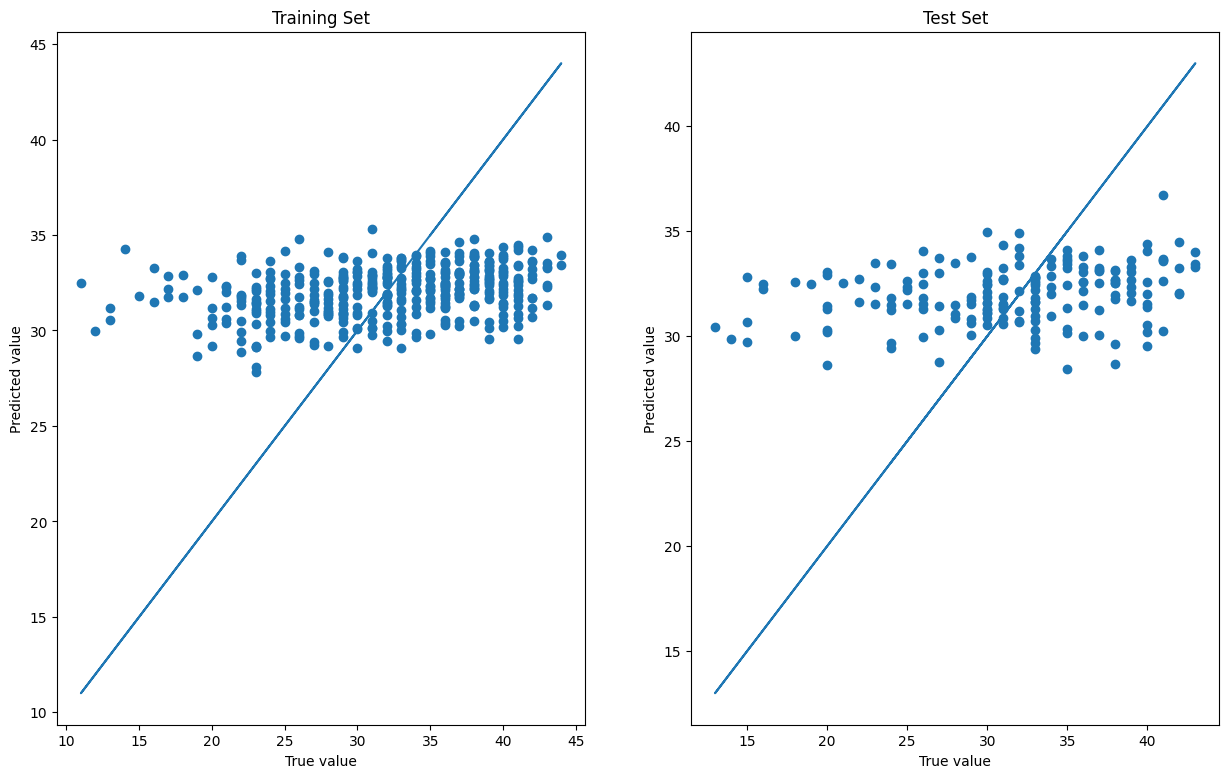

In [478]:
_, (ax0, ax1) = plt.subplots(figsize = (15, 9), ncols=2)

y_train_pred = lr.predict(X_train)
# y_train, y_train_pred = scaler_output.inverse_transform(y_train), scaler_output.inverse_transform(y_train_pred)
print("MSE training : ", mean_squared_error(y_train, y_train_pred))

ax0.scatter(x=y_train, y=y_train_pred)
ax0.plot(y_train, y_train)
ax0.set_title("Training Set")
ax0.set_xlabel("True value")
ax0.set_ylabel("Predicted value")

y_test_pred = lr.predict(X_test)
# y_test, y_test_pred = scaler_output.inverse_transform(y_test), scaler_output.inverse_transform(y_test_pred)
print("MSE test : ", mean_squared_error(y_test, y_test_pred))

ax1.scatter(x=y_test, y=y_test_pred)
ax1.plot(y_test, y_test)
ax1.set_title("Test Set")
ax1.set_xlabel("True value")
ax1.set_ylabel("Predicted value")

print("Pearson correlation test : ", pearsonr(y_test, y_test_pred))
print("ICC test : ", icc(y_test, y_test_pred))


In [308]:
def icc(y_pred, y_true):

    n_subs = y_pred.shape[0] # Change here to get number of participants! 
    n_measurements = 2

    n = n_subs
    k = n_measurements
    df_b = n-1
    df_w = n*(k-1)

    x = np.concatenate([y_true.reshape(-1, 1), y_pred.reshape(-1, 1)], axis = 1)
    x_w_mean = x.mean(axis = 1)
    x_g_mean = x.mean()
    ss_t = ((x - x_g_mean) ** 2).sum()
    ss_w = ((x - np.expand_dims(x_w_mean, axis = 1)) ** 2).sum()
    ss_b = ss_t - ss_w
    ms_b = ss_b / df_b
    ms_w = ss_w / df_w
    icc_score = (ms_b - ms_w) / (ms_b + ((k-1)*ms_w))

    return icc_score

In [309]:
icc(y_test, y_test_pred)

0.41804476161483434

# Benchmark with GridSearch

## Lasso and Ridge

In [ ]:
# To predict
col_to_predict = "Catell_score"
y = demographics[col_to_predict]
y = y.to_numpy()

# Features
X = psds.to_numpy()

# Remove Nan Values
index = np.where(np.isnan(y) == True)[0]
X = np.delete(X, index, axis=0)
y = np.delete(y, index, axis=0)

# Remove the outliers, ex here one with a score of 0
index = np.where(y == 0)[0]
X = np.delete(X, index, axis=0)
y = np.delete(y, index, axis=0)

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [ ]:
# Standardization of the input
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [355]:
score = make_scorer(icc, greater_is_better=True)

### Lasso

In [365]:
parameters = {'fit_intercept':[True, False], 'alpha':[0.01, 0.1, 0.4, 0.75], "tol" : [ 1e-2, 1e-4], "max_iter" : [1000]}
lasso = Lasso()
lr = GridSearchCV(lasso, parameters, cv = 5, scoring=score)
lr.fit(X_train, y_train)


/Users/epideixx/Documents/Neuro_McGill/Fingerprints_Twins/fingerprints_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.621e+03, tolerance: 1.064e+03
  model = cd_fast.enet_coordinate_descent(
/Users/epideixx/Documents/Neuro_McGill/Fingerprints_Twins/fingerprints_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.225e+03, tolerance: 1.144e+03
  model = cd_fast.enet_coordinate_descent(
/Users/epideixx/Documents/Neuro_McGill/Fingerprints_Twins/fingerprints_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Obje

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.01, 0.1, 0.4, 0.75],
                         'fit_intercept': [True, False], 'max_iter': [1000],
                         'tol': [0.01, 0.0001]},
             scoring=make_scorer(icc))

In [366]:
print(lr.best_params_)

{'alpha': 0.1, 'fit_intercept': True, 'max_iter': 1000, 'tol': 0.01}

In [373]:
pd.DataFrame(lr.cv_results_).sort_values(by = ["rank_test_score"])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_fit_intercept,param_max_iter,param_tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,1.975217,0.059768,0.019881,0.007989,0.1,True,1000,0.01,"{'alpha': 0.1, 'fit_intercept': True, 'max_ite...",0.460392,0.503082,0.485263,0.486431,0.518113,0.490656,0.019345,1
5,0.412345,0.038629,0.119185,0.046939,0.1,True,1000,0.0001,"{'alpha': 0.1, 'fit_intercept': True, 'max_ite...",0.460392,0.503082,0.485263,0.486431,0.518113,0.490656,0.019345,1
8,0.207042,0.105247,0.042522,0.014827,0.4,True,1000,0.01,"{'alpha': 0.4, 'fit_intercept': True, 'max_ite...",0.483099,0.540896,0.439921,0.481780,0.469947,0.483128,0.032801,3
9,0.411899,0.165989,0.031413,0.030123,0.4,True,1000,0.0001,"{'alpha': 0.4, 'fit_intercept': True, 'max_ite...",0.487616,0.534088,0.434324,0.480269,0.465342,0.480328,0.032509,4
12,0.095565,0.063505,0.020419,0.007174,0.75,True,1000,0.01,"{'alpha': 0.75, 'fit_intercept': True, 'max_it...",0.439301,0.480330,0.393417,0.417292,0.418010,0.429670,0.029198,5
13,0.176719,0.030809,0.027933,0.012871,0.75,True,1000,0.0001,"{'alpha': 0.75, 'fit_intercept': True, 'max_it...",0.442119,0.474990,0.396611,0.412603,0.420780,0.429421,0.027099,6
0,2.294850,0.136471,0.013534,0.006160,0.01,True,1000,0.01,"{'alpha': 0.01, 'fit_intercept': True, 'max_it...",0.265940,0.399762,0.337428,0.319636,0.379932,0.340540,0.047055,7
1,0.489466,0.036780,0.104084,0.068894,0.01,True,1000,0.0001,"{'alpha': 0.01, 'fit_intercept': True, 'max_it...",0.265940,0.399762,0.337428,0.319636,0.379932,0.340540,0.047055,7
2,2.175912,0.052945,0.035170,0.046489,0.01,False,1000,0.01,"{'alpha': 0.01, 'fit_intercept': False, 'max_i...",-0.443529,-0.328909,-0.322359,-0.258315,-0.278472,-0.326317,0.064303,9
3,0.503450,0.045727,0.171602,0.040875,0.01,False,1000,0.0001,"{'alpha': 0.01, 'fit_intercept': False, 'max_i...",-0.443529,-0.328909,-0.322359,-0.258315,-0.278472,-0.326317,0.064303,9


In [374]:
parameters = {'fit_intercept':[True], 'alpha':[0.1, 0.25, 0.4, 0.75], "tol" : [ 1e-4], "max_iter" : [1000]}
lasso = Lasso()
lr = GridSearchCV(lasso, parameters, cv = 5, scoring=score)
lr.fit(X_train, y_train)


/Users/epideixx/Documents/Neuro_McGill/Fingerprints_Twins/fingerprints_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.470e+03, tolerance: 1.064e+01
  model = cd_fast.enet_coordinate_descent(
/Users/epideixx/Documents/Neuro_McGill/Fingerprints_Twins/fingerprints_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.837e+03, tolerance: 1.144e+01
  model = cd_fast.enet_coordinate_descent(
/Users/epideixx/Documents/Neuro_McGill/Fingerprints_Twins/fingerprints_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Obje

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.1, 0.25, 0.4, 0.75],
                         'fit_intercept': [True], 'max_iter': [1000],
                         'tol': [0.0001]},
             scoring=make_scorer(icc))

In [375]:
pd.DataFrame(lr.cv_results_).sort_values(by = ["rank_test_score"])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_fit_intercept,param_max_iter,param_tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.354086,0.035586,0.124022,0.044404,0.25,True,1000,0.0001,"{'alpha': 0.25, 'fit_intercept': True, 'max_it...",0.513578,0.554054,0.465751,0.509430,0.501296,0.508822,0.028216,1
0,0.369872,0.041955,0.037123,0.021187,0.1,True,1000,0.0001,"{'alpha': 0.1, 'fit_intercept': True, 'max_ite...",0.460392,0.503082,0.485263,0.486431,0.518113,0.490656,0.019345,2
2,0.279986,0.055840,0.040355,0.020280,0.4,True,1000,0.0001,"{'alpha': 0.4, 'fit_intercept': True, 'max_ite...",0.487616,0.534088,0.434324,0.480269,0.465342,0.480328,0.032509,3
3,0.162392,0.029382,0.051628,0.051923,0.75,True,1000,0.0001,"{'alpha': 0.75, 'fit_intercept': True, 'max_it...",0.442119,0.474990,0.396611,0.412603,0.420780,0.429421,0.027099,4


MSE training :  141.9149032781545
MSE test :  237.13803469912838
Correlation test :  PearsonRResult(statistic=0.5945604584542123, pvalue=8.836538856112253e-19)
ICC test :  0.5325129670947777


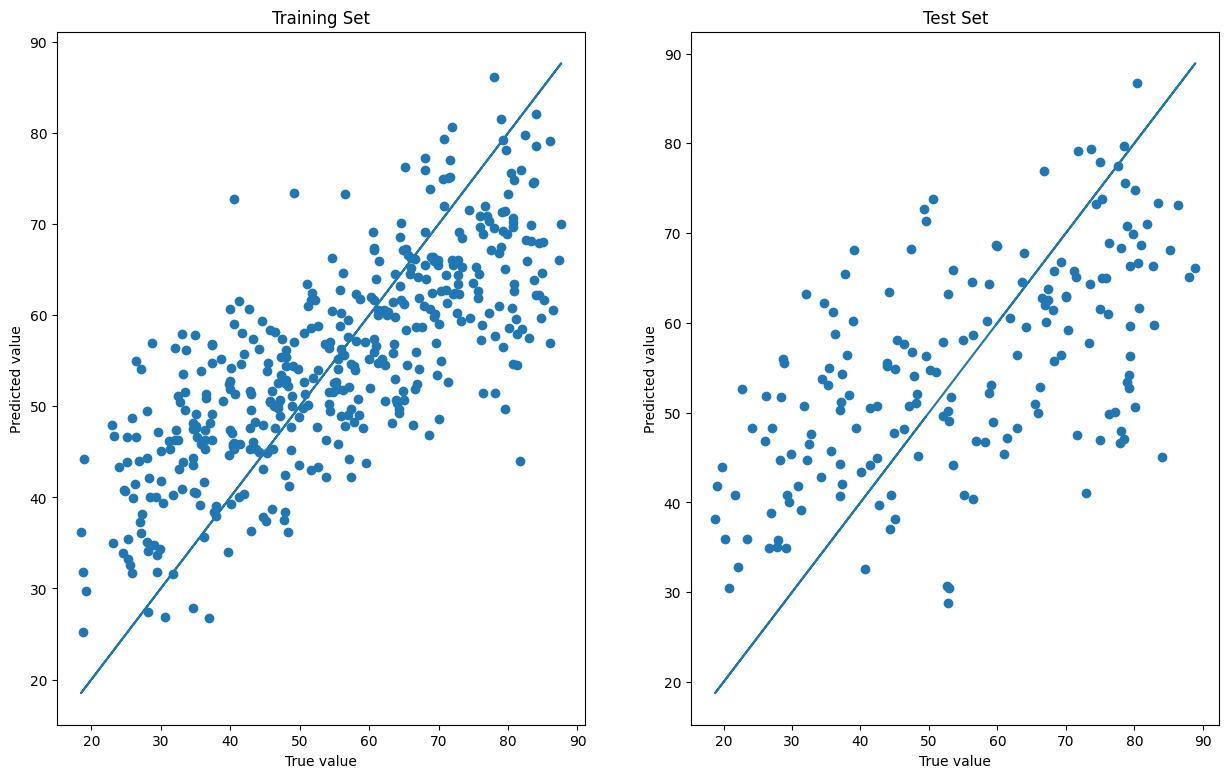

In [376]:
_, (ax0, ax1) = plt.subplots(figsize = (15, 9), ncols=2)

y_train_pred = lr.predict(X_train)
# y_train, y_train_pred = scaler_output.inverse_transform(y_train), scaler_output.inverse_transform(y_train_pred)
print("MSE training : ", mean_squared_error(y_train, y_train_pred))

ax0.scatter(x=y_train, y=y_train_pred)
ax0.plot(y_train, y_train)
ax0.set_title("Training Set")
ax0.set_xlabel("True value")
ax0.set_ylabel("Predicted value")

y_test_pred = lr.predict(X_test)
# y_test, y_test_pred = scaler_output.inverse_transform(y_test), scaler_output.inverse_transform(y_test_pred)
print("MSE test : ", mean_squared_error(y_test, y_test_pred))

ax1.scatter(x=y_test, y=y_test_pred)
ax1.plot(y_test, y_test)
ax1.set_title("Test Set")
ax1.set_xlabel("True value")
ax1.set_ylabel("Predicted value")

print("Correlation test : ", pearsonr(y_test, y_test_pred))
print("ICC test : ", icc(y_test, y_test_pred))


### Ridge

In [388]:
parameters = {'fit_intercept':[True, False], 'alpha':[50, 75, 100, 125], "tol" : [ 1e-4], "max_iter" : [1000], "solver" : ["auto"]}
lasso = Ridge()
lr = GridSearchCV(lasso, parameters, cv = 5, scoring=score)
lr.fit(X_train, y_train)

print(lr.best_params_)
pd.DataFrame(lr.cv_results_).sort_values(by = ["rank_test_score"])

{'alpha': 75, 'fit_intercept': True, 'max_iter': 1000, 'solver': 'auto', 'tol': 0.0001}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_fit_intercept,param_max_iter,param_solver,param_tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.511147,0.031230,0.015030,0.013130,75,True,1000,auto,0.0001,"{'alpha': 75, 'fit_intercept': True, 'max_iter...",0.478734,0.542548,0.507829,0.504481,0.529156,0.512549,0.021939,1
4,0.482067,0.050043,0.006646,0.004950,100,True,1000,auto,0.0001,"{'alpha': 100, 'fit_intercept': True, 'max_ite...",0.484034,0.545106,0.501630,0.502880,0.521630,0.511056,0.020770,2
0,0.433916,0.071063,0.019580,0.010509,50,True,1000,auto,0.0001,"{'alpha': 50, 'fit_intercept': True, 'max_iter...",0.467808,0.532646,0.512593,0.501271,0.537499,0.510363,0.025026,3
6,0.420351,0.098573,0.007006,0.003500,125,True,1000,auto,0.0001,"{'alpha': 125, 'fit_intercept': True, 'max_ite...",0.486501,0.544294,0.495239,0.499419,0.514861,0.508063,0.020312,4
1,0.466534,0.061450,0.021801,0.014050,50,False,1000,auto,0.0001,"{'alpha': 50, 'fit_intercept': False, 'max_ite...",-0.677936,-0.721990,-0.606528,-0.579793,-0.675749,-0.652399,0.051800,5
3,0.464945,0.020728,0.024705,0.016505,75,False,1000,auto,0.0001,"{'alpha': 75, 'fit_intercept': False, 'max_ite...",-0.691770,-0.744063,-0.628473,-0.621549,-0.699483,-0.677068,0.046154,6
5,0.477102,0.051368,0.008952,0.007561,100,False,1000,auto,0.0001,"{'alpha': 100, 'fit_intercept': False, 'max_it...",-0.698422,-0.753683,-0.637974,-0.646877,-0.710541,-0.689500,0.042693,7
7,0.404778,0.085402,0.007689,0.012264,125,False,1000,auto,0.0001,"{'alpha': 125, 'fit_intercept': False, 'max_it...",-0.702097,-0.758437,-0.642459,-0.663682,-0.716601,-0.696655,0.040667,8


MSE training :  98.8967124914634
MSE test :  240.22024638913302
Correlation test :  PearsonRResult(statistic=0.5899862385527561, pvalue=1.886947195717016e-18)
ICC test :  0.5403686229394637


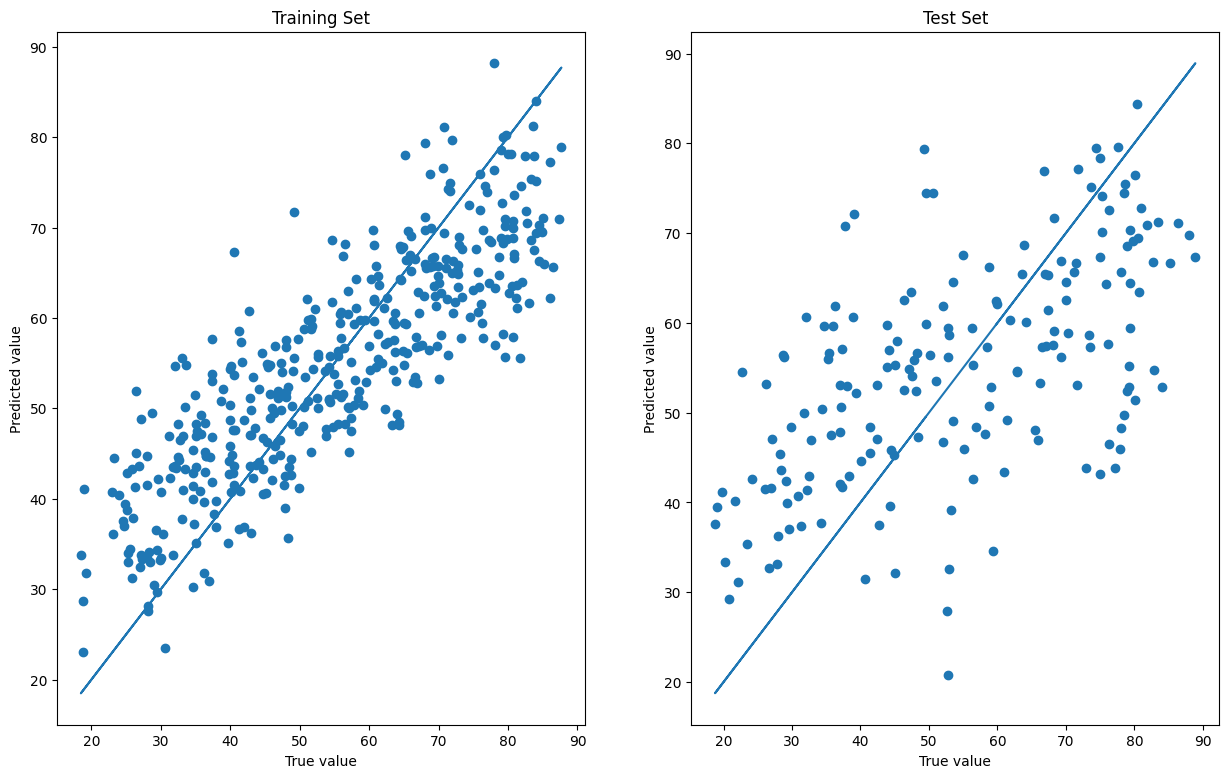

In [389]:
_, (ax0, ax1) = plt.subplots(figsize = (15, 9), ncols=2)

y_train_pred = lr.predict(X_train)
# y_train, y_train_pred = scaler_output.inverse_transform(y_train), scaler_output.inverse_transform(y_train_pred)
print("MSE training : ", mean_squared_error(y_train, y_train_pred))

ax0.scatter(x=y_train, y=y_train_pred)
ax0.plot(y_train, y_train)
ax0.set_title("Training Set")
ax0.set_xlabel("True value")
ax0.set_ylabel("Predicted value")

y_test_pred = lr.predict(X_test)
# y_test, y_test_pred = scaler_output.inverse_transform(y_test), scaler_output.inverse_transform(y_test_pred)
print("MSE test : ", mean_squared_error(y_test, y_test_pred))

ax1.scatter(x=y_test, y=y_test_pred)
ax1.plot(y_test, y_test)
ax1.set_title("Test Set")
ax1.set_xlabel("True value")
ax1.set_ylabel("Predicted value")

print("Correlation test : ", pearsonr(y_test, y_test_pred))
print("ICC test : ", icc(y_test, y_test_pred))


## Other models

# Comparison features

In [457]:
# Import heritability for DK

path = "Results_Log_DK/ICC_and_Heritability/heritability_mean.csv"
heritability = pd.read_csv(path, index_col=0)
heritability = heritability.drop(columns=[str(150.0)]) # Because not in CamCAN

# Features
heritability_flatten = {roi + "_" + str(freq) : heritability.loc[roi, freq] for roi in heritability.index for freq in heritability.columns}

ICCs = {}
for nb_features in [10, 100, 500, 1000, 2000]:

    # Select features
    top_h = sorted(heritability_flatten, key=heritability_flatten.get, reverse=True)[:nb_features]
    bottom_h = sorted(heritability_flatten, key=heritability_flatten.get, reverse=True)[-nb_features:]
    random_h = np.random.choice(list(heritability_flatten.keys()), size = nb_features)

    for name, choose_feature in {"top_h" : top_h, "bottom_h": bottom_h, "random_h": random_h}.items():

        # Bootstrapping
        ICCs[name + "_" + str(nb_features)] = []
        for _ in tqdm(range(200), total = 200):

            # To predict
            col_to_predict = "Catell_score"
            y = demographics[col_to_predict]
            y = y.to_numpy()   

            # Features
            if name == "random_h":
                choose_feature = np.random.choice(list(heritability_flatten.keys()), size = nb_features)

            X = psds[choose_feature]
            X = X.to_numpy()

            # Remove Nan Values
            index = np.where(np.isnan(y) == True)[0]
            X = np.delete(X, index, axis=0)
            y = np.delete(y, index, axis=0)

            # Remove the outliers, ex here one with a score of 0
            index = np.where(y == 0)[0]
            X = np.delete(X, index, axis=0)
            y = np.delete(y, index, axis=0)

            # Train-Test split
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

            # Standardization of the input
            scaler = StandardScaler()

            X_train = scaler.fit_transform(X_train)
            X_test = scaler.fit_transform(X_test)# Linear Rigde Regression
            
            lr = Lasso(alpha=0.25)
            lr.fit(X_train, y_train)

            y_test_pred = lr.predict(X_test)
            icc_score = icc(y_test, y_test_pred)
            ICCs[name + "_" + str(nb_features)].append(icc_score)



100%|██████████| 200/200 [01:06<00:00,  2.99it/s]


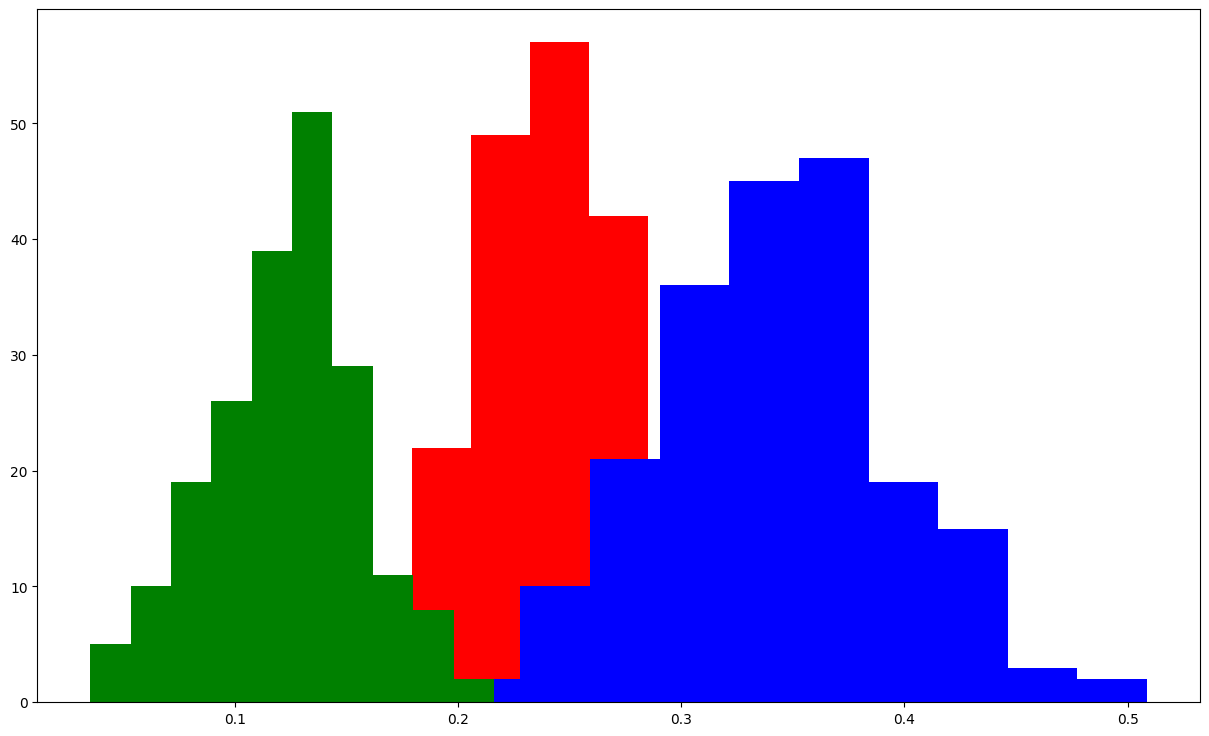

In [461]:
plt.figure(figsize=(15, 9))
           
plt.hist(ICCs["top_h_100"], color = "red")
plt.hist(ICCs["random_h_100"], color = "blue")
plt.hist(ICCs["bottom_h_100"], color = "green")

plt.show()

In [451]:
# NOTE : Improve random by modifying it at each part of the benchmark

# Ideas

- Use ICC instead of Pearson because we want X = y
- Benchmark models with GridSearch for the moment
- Create model which predicts age and then second one using this prediction to predict new score
- Run bootstrapping/ Model multi times to collect scores